<a href="https://colab.research.google.com/github/amirarasteh1990/PythonCodes_ChatGPT/blob/main/Topfarm_and_Edwin_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## INSTALL ALL REQUIRED PACKAGES
import importlib
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray]

  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to /tmp/pip-req-build-xa26qe5g
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git /tmp/pip-req-build-xa26qe5g
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to commit 167c915aa0020f011ce392538e0962e5b5842de2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
  Created wheel for py_wake: filename=py_wake-2.5.1.dev62+g167c915-py3-none-any.whl size=97196221 sha256=1d810cc0427e7d6865de85cd5c7b1b7da89f526de766c65ae80992977a288fc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-li3vtstr/wheels/eb/a5/d1/e7380004c5b927c92dd3bfb3a466983ecefc2e7119756db77d
Successfully built py_wake

In [1]:
## IMPORT ALL REQUIRED FUNCTIONS

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from openmdao.api import n2

from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.hornsrev1 import wt_x, wt_y, HornsrevV80, Hornsrev1Site
from py_wake import NOJ
from py_wake.utils.gradients import autograd

from ed_win.wind_farm_network import WindFarmNetwork

In [4]:
## SETUP OF WIND FARM MODEL

x_init = np.array(wt_x)[np.array([0, 1, 8, 9])]
y_init = np.array(wt_y)[np.array([0, 1, 8, 9])]
n_wt = len(x_init)
wt = HornsrevV80()
site = Hornsrev1Site()
wf_model = NOJ(site, wt)
aep = wf_model(wt_x, wt_y).aep()

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


In [5]:
## SETUP OF ELECTRICAL COLLECTION SYSTEM MODEL

turbines_pos=np.asarray([wt_x, wt_y]).T
substations_pos = np.asarray([[359470], [6153890]]).T

cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])

wfn = WindFarmNetwork(turbines_pos=turbines_pos, substations_pos=substations_pos, cables=cables)

In [6]:
## SETUP OF ECONOMICAL MODEL

Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20))*1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.4               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
# water_depth_array = [15] * n_wt  # [m]
eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)

In [7]:
## SETUP OF WRAPPER FUNCTIONS

def waterdepth_func(x, y, **kwargs):
  # insert a good water depth model here
  return 20

def cable_func(x, y, x_substation, y_substation, **kwargs):
  G = wfn.optimize(turbines_pos= np.asarray([x, y]).T)
  return G.size(weight="cost")

def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return [eco_eval.NPV, CAPEX, OPEX]

In [8]:
## SETUP OF COMPONENTS

aep_component = PyWakeAEPCostModelComponent(wf_model, n_wt, grad_method=autograd, objective=False)

water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=waterdepth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', 359470), ('y_substation', 6153890)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 1000)])

npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 1000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0), ('CAPEX', 0), ('OPEX', 0)])

cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_component, npv_comp])

In [9]:
## SETUP OF PROBLEM

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init, 'x_substation': 359470, 'y_substation': 6153890},
                  cost_comp=cost_comp,
                  constraints=[XYBoundaryConstraint(np.asarray([x_init, y_init]).T, boundary_type='rectangle'),
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp())

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


Solving with heuristic(cpew)



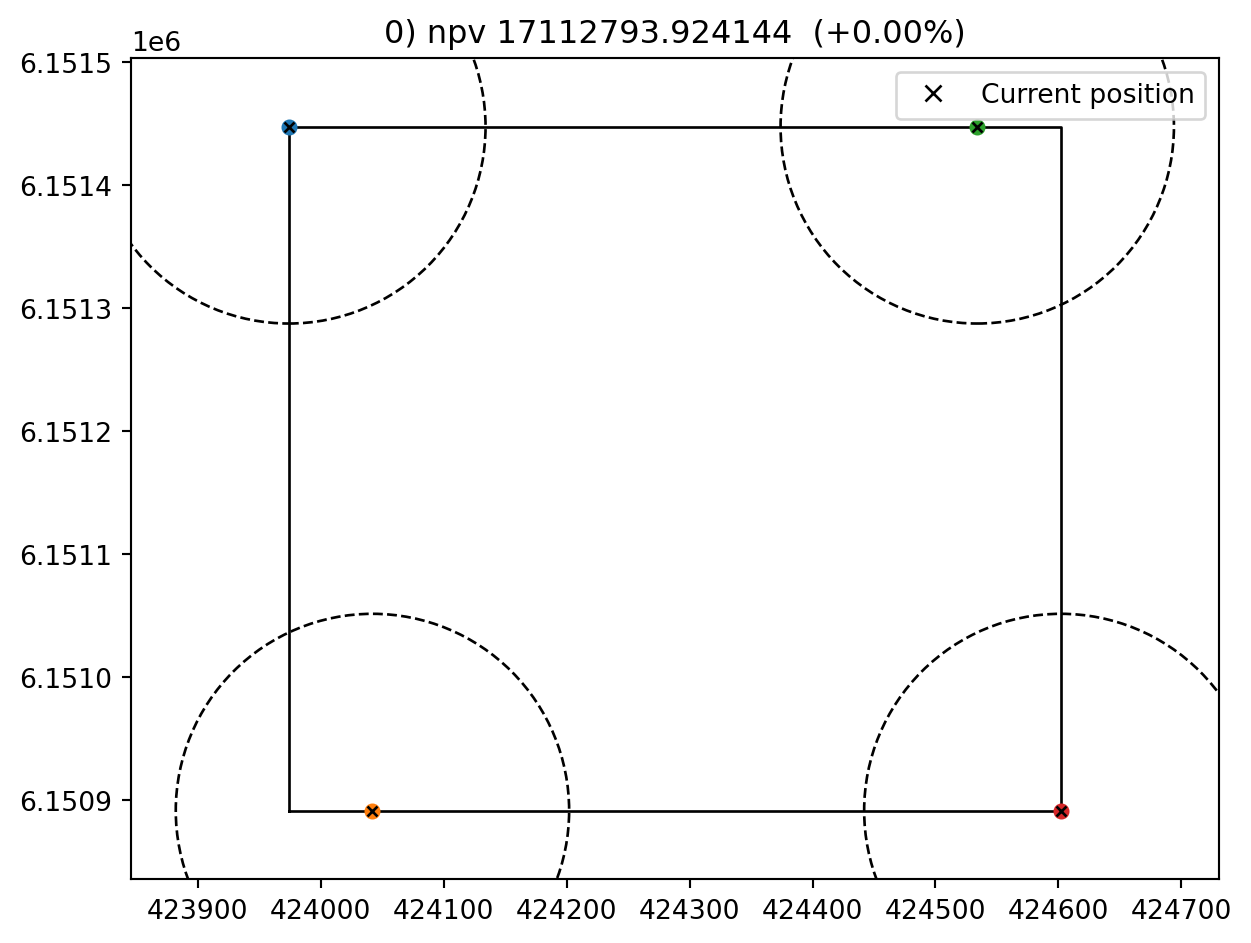

(-17112793.92414431,
 {'x': array([423974., 424042., 424534., 424602.]),
  'y': array([6151447., 6150891., 6151447., 6150891.]),
  'x_substation': array([359470.]),
  'y_substation': array([6153890.])})

In [10]:
problem.evaluate()

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Solving with heuristic(cpew)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -17325694.33477038
            Iterations: 6
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


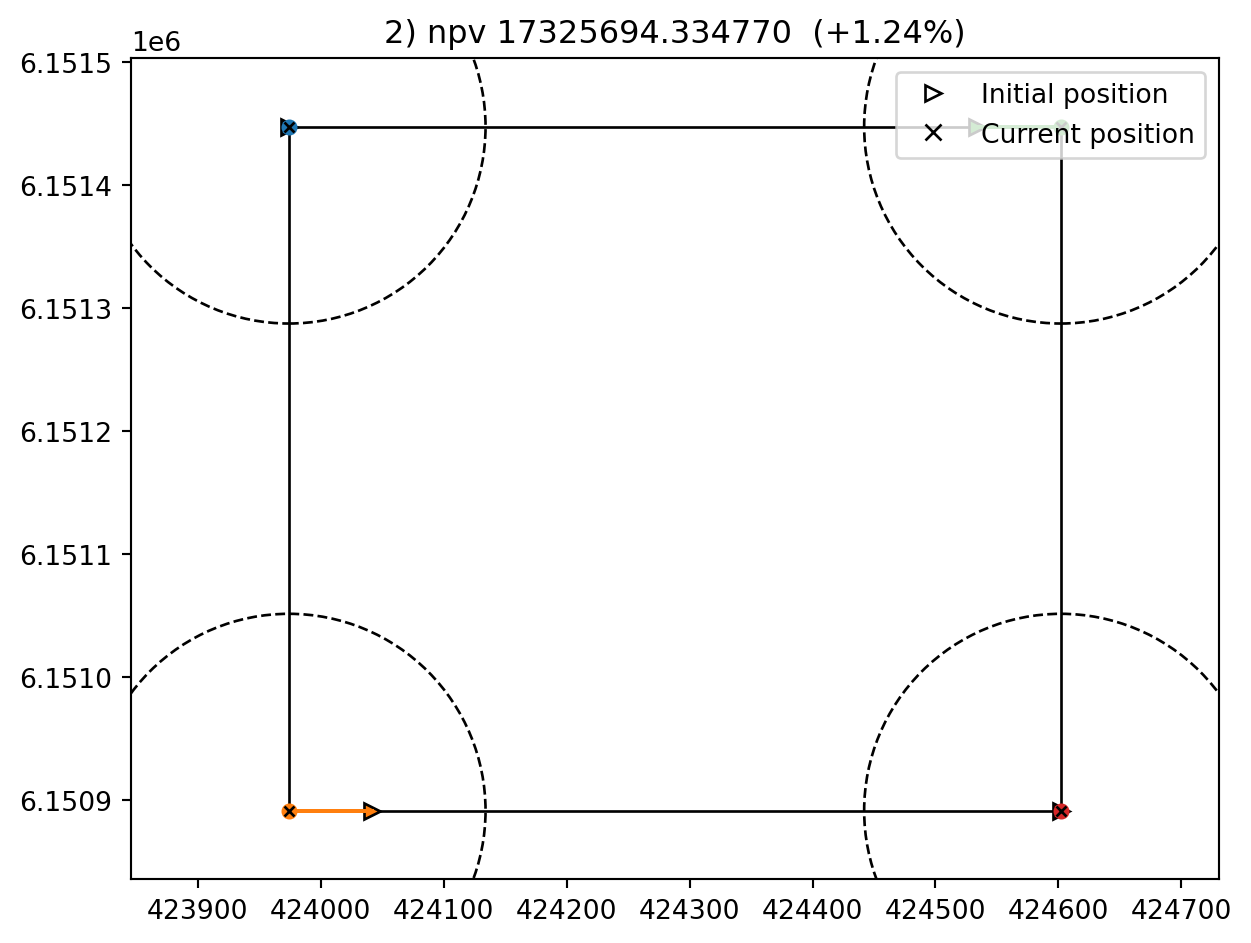

In [11]:
cost, state, recorder = problem.optimize()


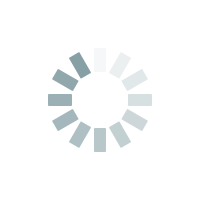
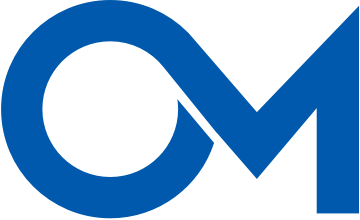
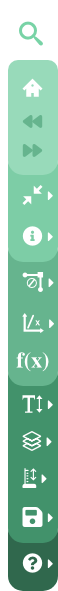

In [12]:
## PLOT N2 DIAGRAM TO INSPECT YOUR PROBLEM SETUP

n2(problem, display_in_notebook=True)

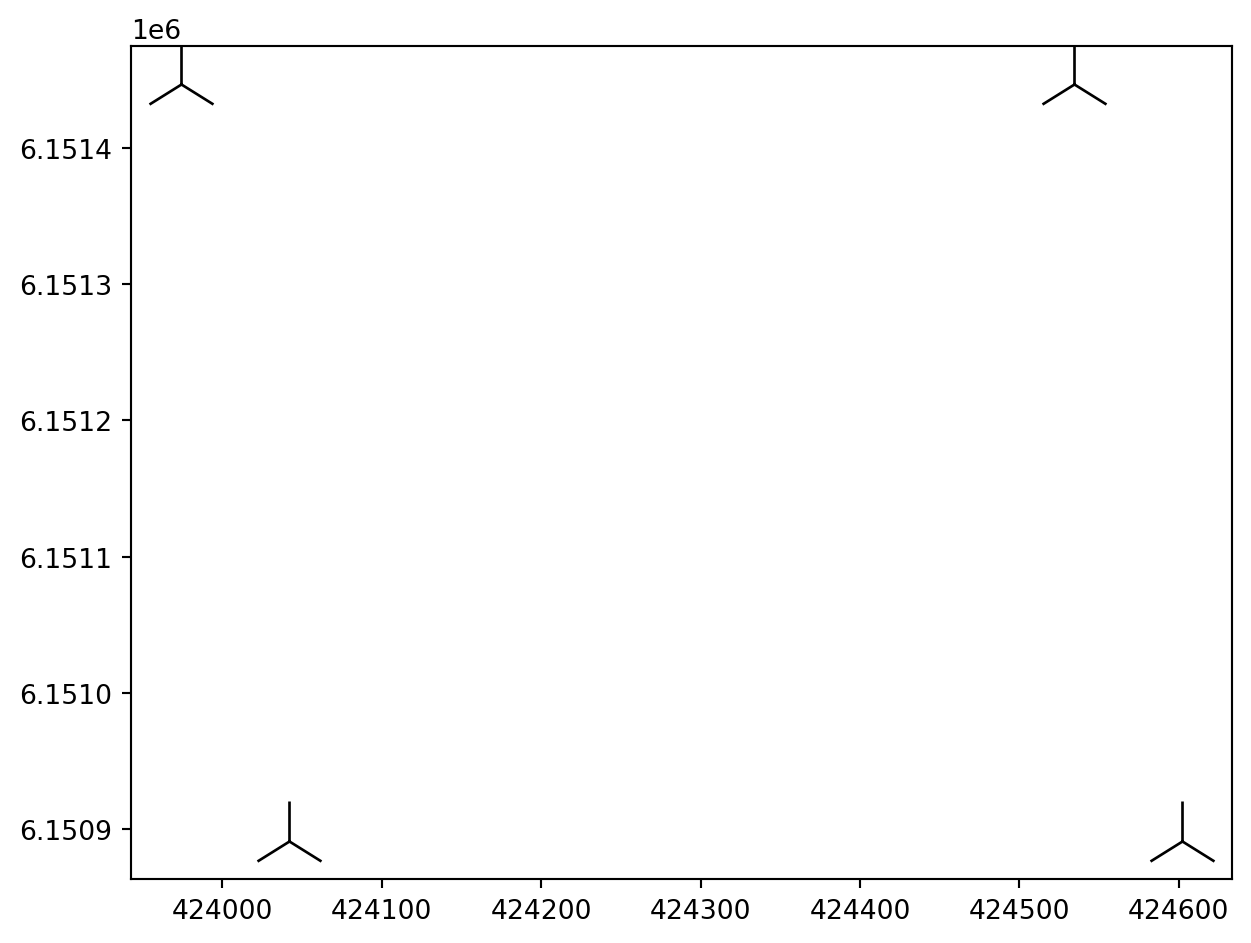

In [13]:
## PLOT WIND FARM

plt.plot(x_init, y_init, '2k', markersize=30)

Text(0, 0.5, 'npv [EUR]')

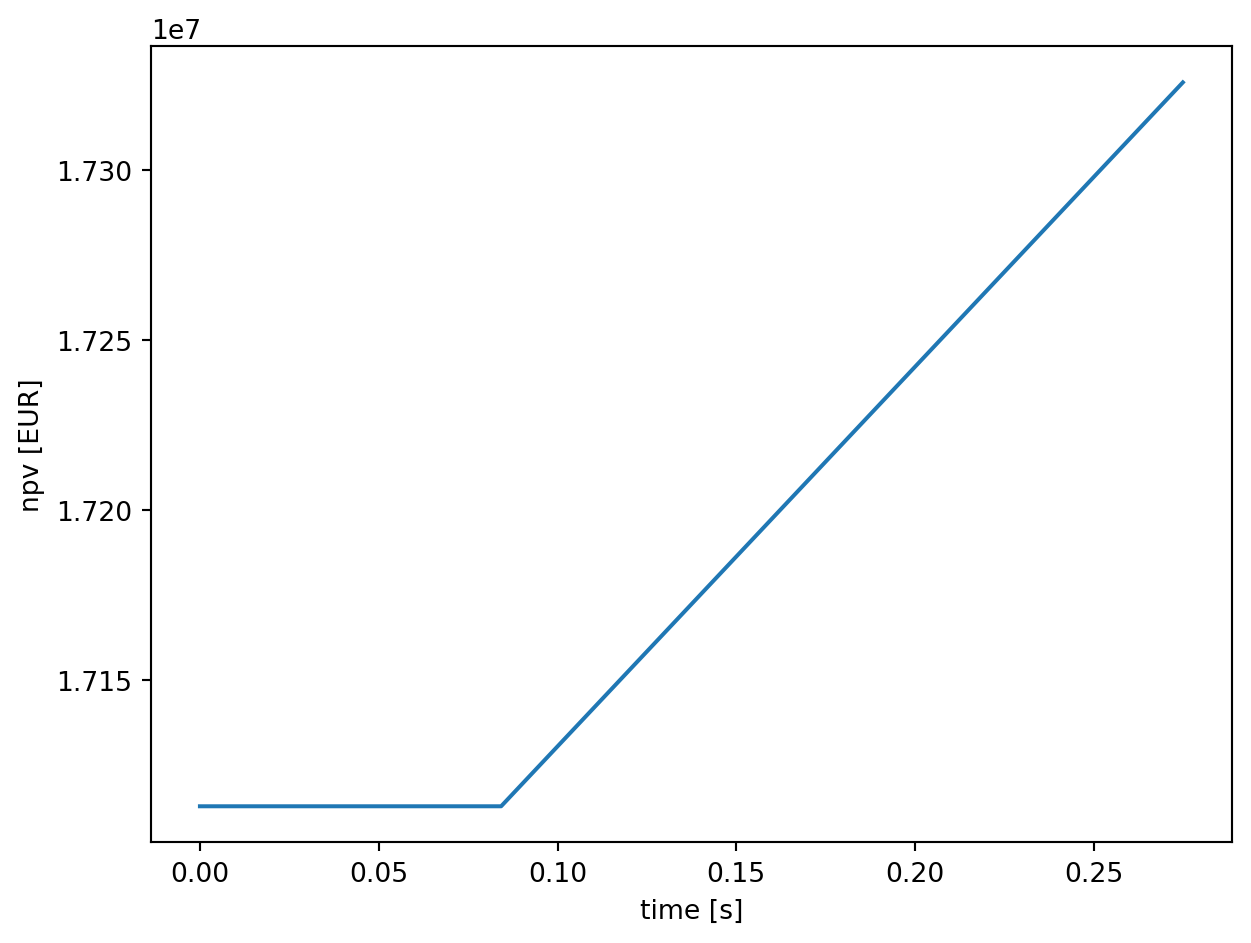

In [14]:
## ACCESSING DATA

fig = plt.figure()
plt.plot(recorder['timestamp']-recorder['timestamp'][0], recorder['npv'])
plt.xlabel("time [s]")
plt.ylabel("npv [EUR]")


In [15]:
problem['CAPEX']

array([64879340.55218639])

In [16]:
problem["OPEX"]

array([4126800.])

In [ ]:
turbines_pos=np.asarray([problem['x'], problem['y']]).T
substations_pos = np.asarray([problem['x_substation'], problem['y_substation']]).T
G = wfn.optimize(turbines_pos, substations_pos=substations_pos)

<Axes: >

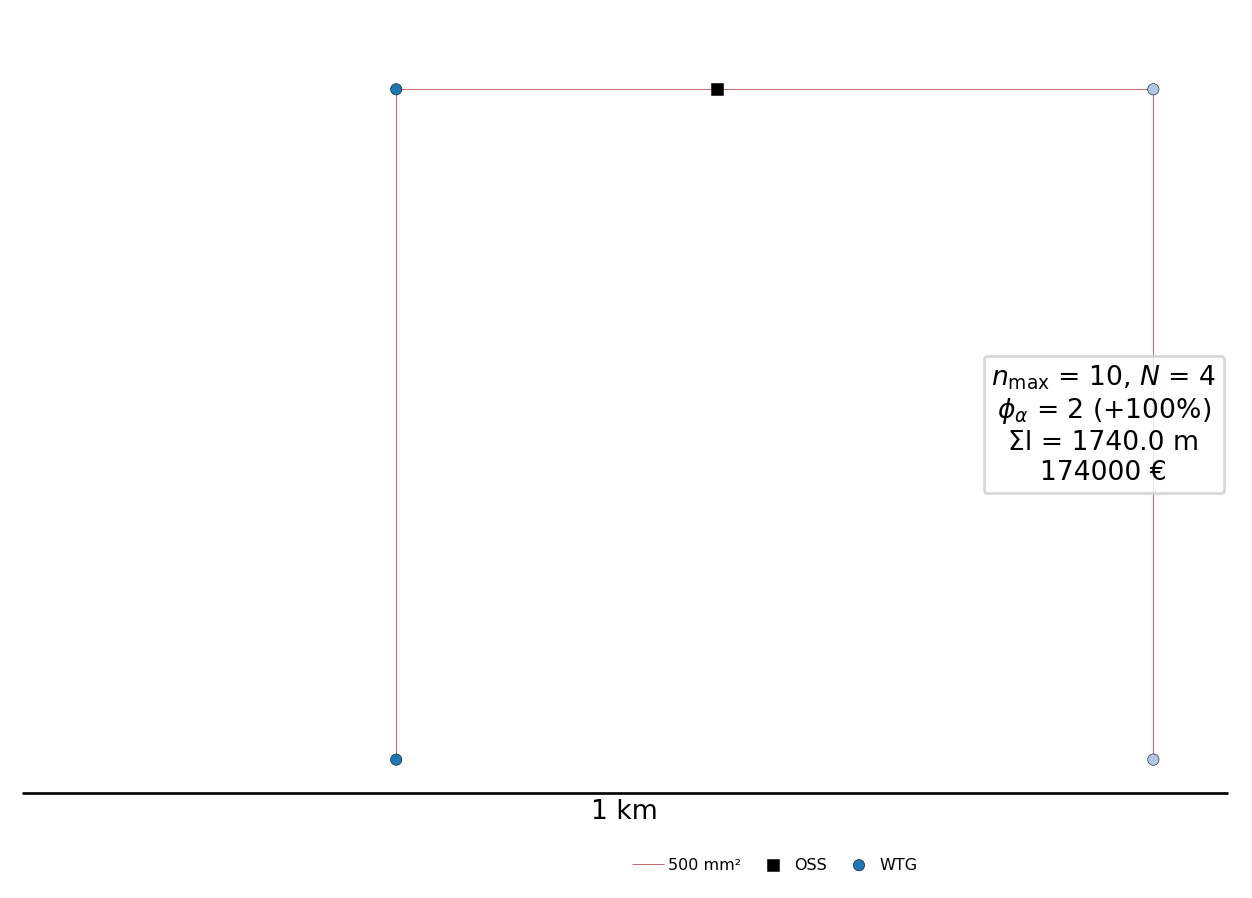

In [ ]:
G.plot()